In [ ]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from google.colab import drive, files

from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, f1_score
import tensorflow as tf
from tensorflow import keras

# Display all columns for better visualization
pd.set_option('display.max_columns', None)

# Initial data reading
files.upload()
df = pd.read_csv("diabetic_data.csv")
print("The original data has {} features and {} observations".format(df.shape[1], df.shape[0]))
display(df.head(3))
display(df.info())

Saving diabetic_data_processed.csv to diabetic_data_processed (2).csv
The original data has 50 features and 101766 observations


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

None

#1. Analisis Exploratorio (EDA) y Preprocesamiento de Datos

##1.1 Datos perdidos y variables no-informativas

In [ ]:
na = pd.DataFrame(df.isna().sum()).rename(columns={0:'# Null Values'})
display(na[na['# Null Values']>0])

,# Null Values


Con los datos prcesados previamente no se evidencian datos perdidos.

In [ ]:
df.drop(['citoglipton', 'examide', 'encounter_id', 'patient_nbr', 'admission_type_id','discharge_disposition_id','admission_source_id'], axis = 1, inplace=True)


Eliminamos variables que no haran parte del analisis descriptivo de la tabla preparada

##1.2 Distribución de las clases en la variable objetivo

Dado que nuestra característica objetivo es "readmitted" en este caso, exploraremos los valores necesarios para asegurarnos de que sea consistente y también verificaremos la frecuencia de cada categoría para explorar la presencia de desequilibrio de clases.

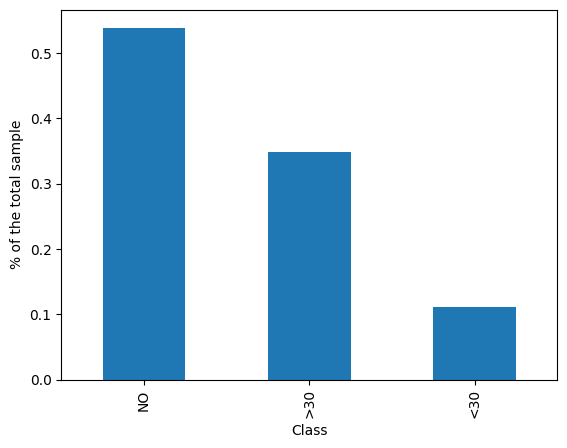

In [ ]:
df['readmitted'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('% of the total sample')
plt.show()

Del gráfico anterior podemos decir que tanto las clases '>30' como '<30' están moderadamente desequilibradas. Para solucionar esto, podríamos experimentar submuestreo o sobremuestreo (SMOTE) para obtener clases más equilibradas, pero como el desequilibrio no es grave, continuaremos con los datos tal como están, usando StratifiedKFold para solucionar esto, como veremos. más tarde.

##1.3 Analisis Descriptivo

Comenzamos trazando histogramas y diagramas de dispersión con regresiones lineales en todas las características numéricas. Esto nos ayudará a comprender la distribución de cada característica junto con la naturaleza de las relaciones entre variables. Toda esta información nos orienta a la hora de tomar decisiones como la necesidad de estandarizar/escalar nuestros datos y los tipos de modelos que debemos probar.

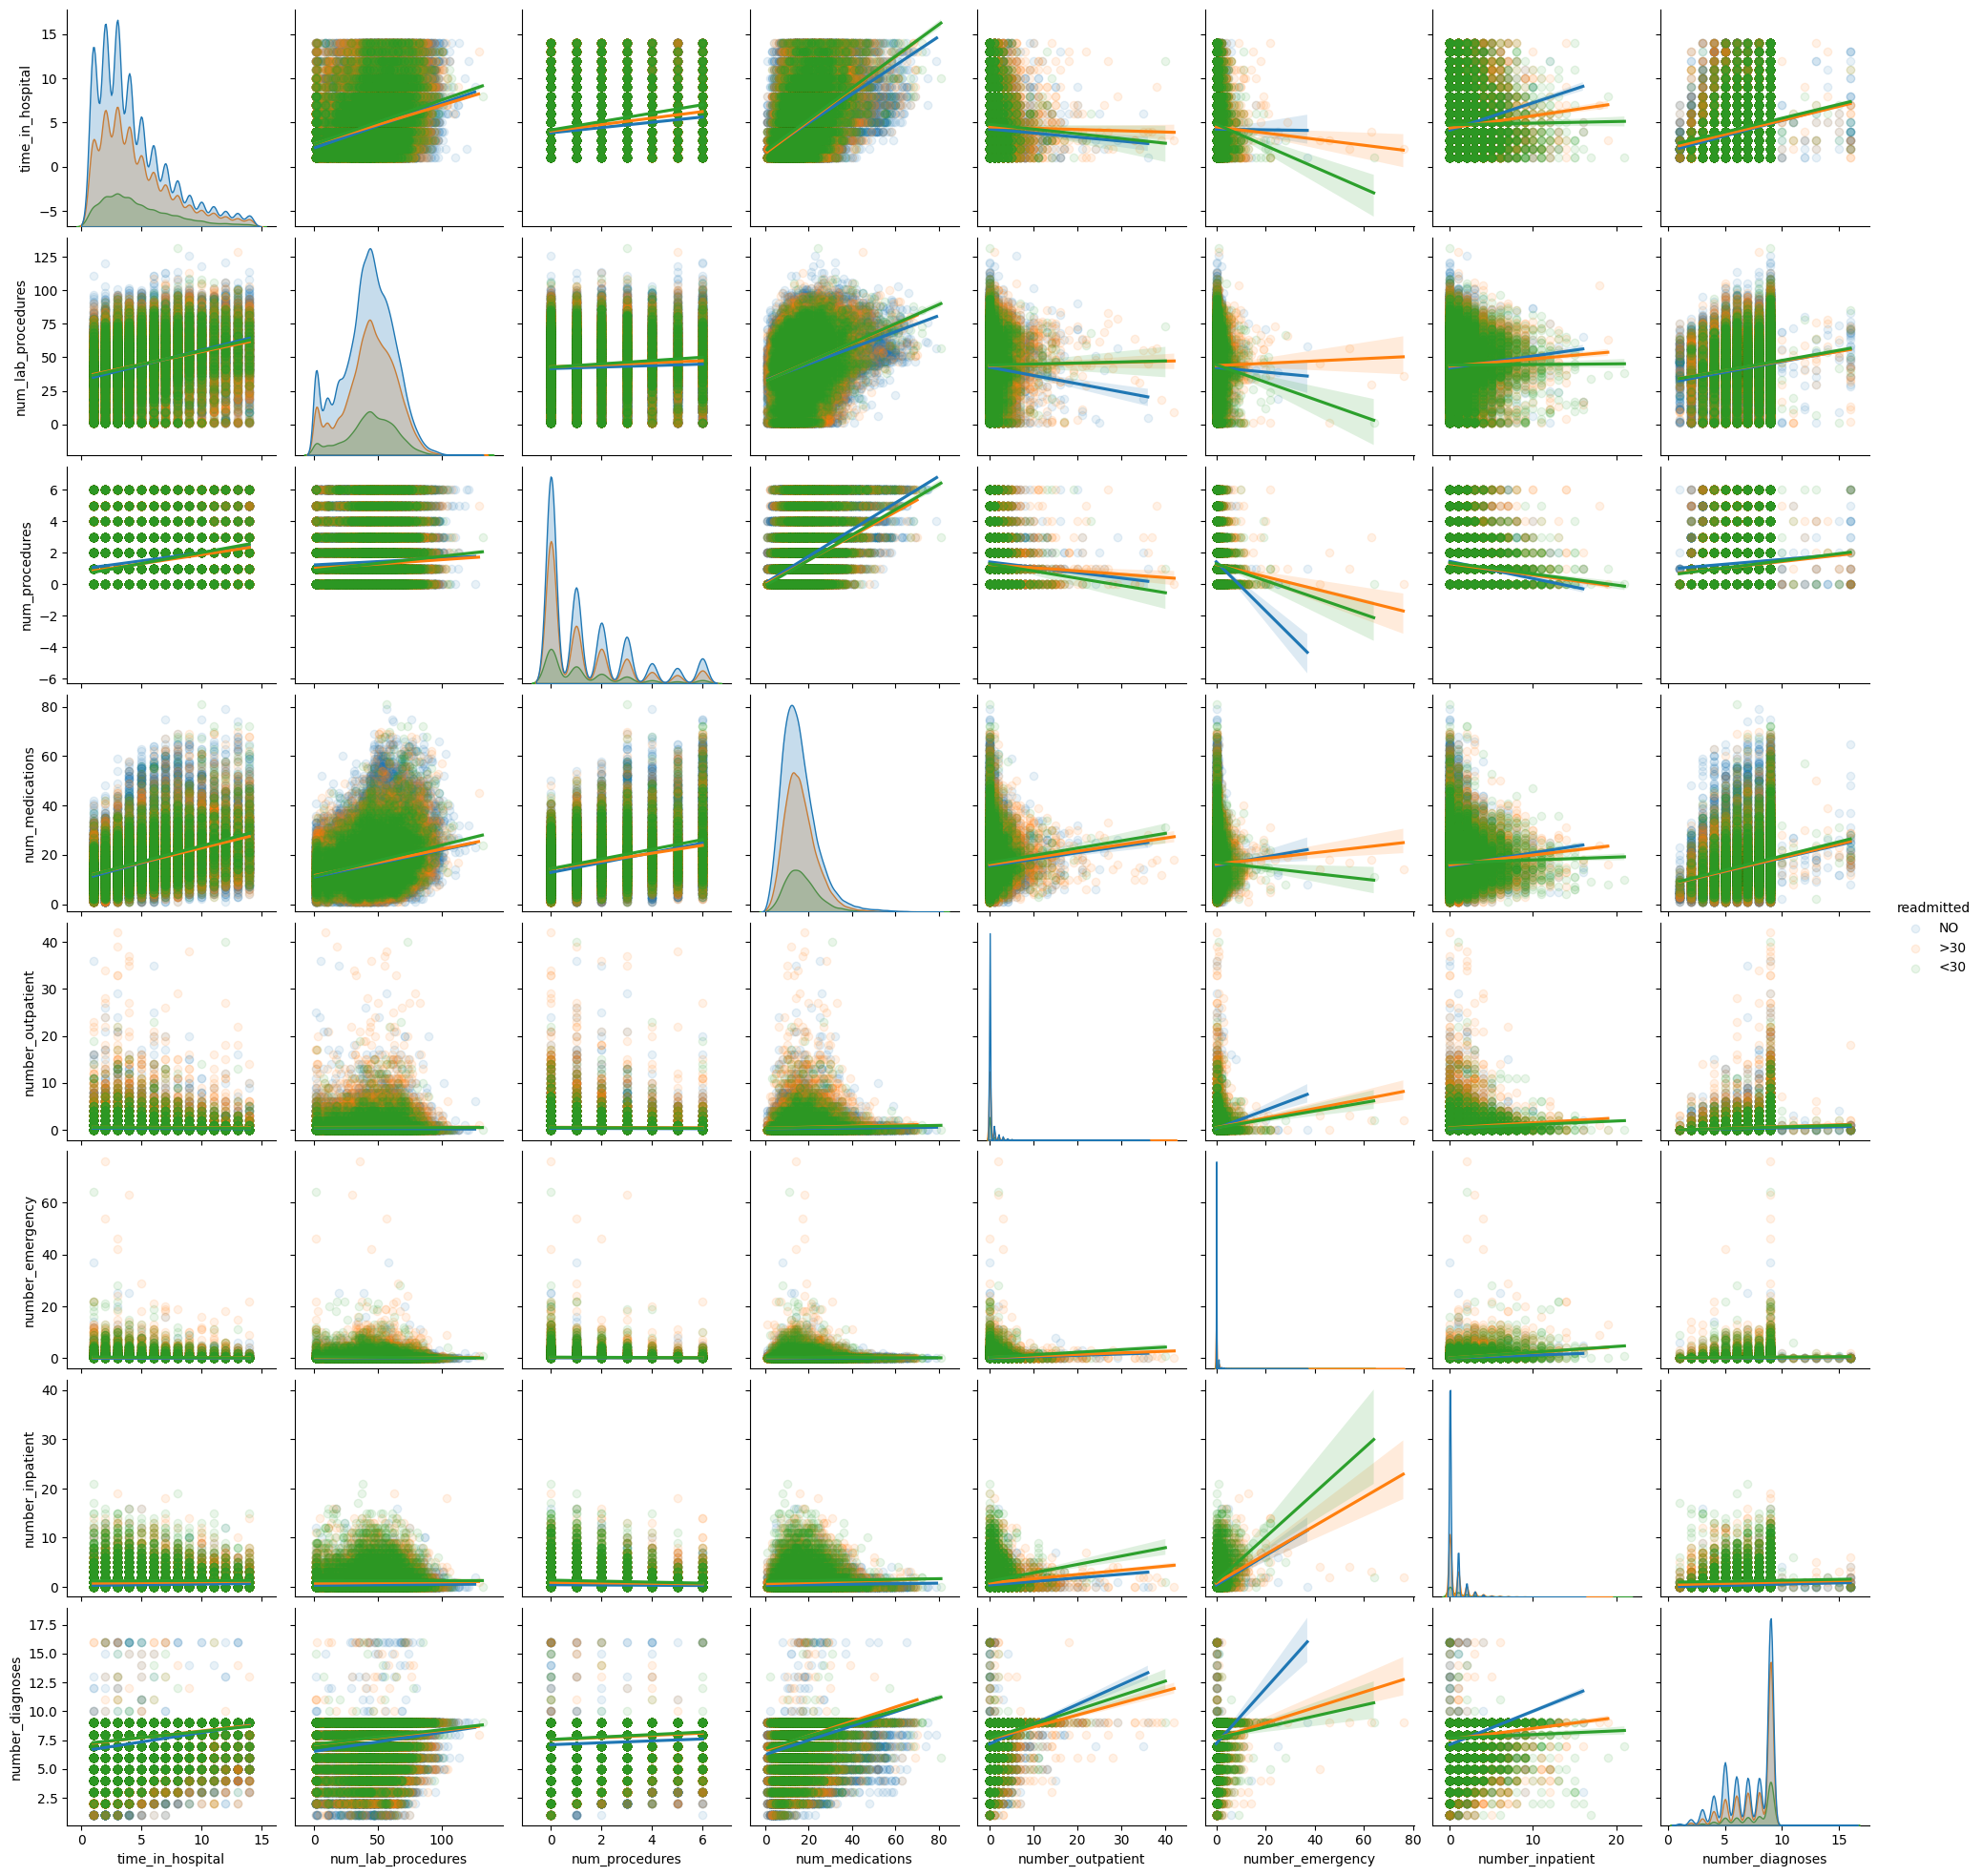

In [ ]:
sns.pairplot(df, kind='reg', hue='readmitted', plot_kws={'scatter_kws': {'alpha': 0.1}})
plt.show()

Este diagrama de pares es muy informativo antes de comenzar cualquier tipo de modelado. Primero, en los gráficos de densidad en la diagonal podemos ver que hay múltiples distribuciones, algunas muy asimétricas. Y al revisar los diagramas de dispersión vemos muchas relaciones que claramente no son lineales.

Lo que esto nos dice es que probablemente se necesiten algunas escalas y estandarizaciones, y que es posible que los modelos lineales no puedan representar correctamente patrones en los datos. En estos casos, los modelos no lineales como Random Forest, Gradient Boosting y Neural Networks suelen ser más efectivos.

A continuación, construimos una matriz de correlación para explorar la colinealidad dentro de nuestro conjunto de datos.

In [ ]:
df.corr().style.background_gradient(cmap='coolwarm')

<ipython-input-56-699201837c09>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().style.background_gradient(cmap='coolwarm')


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
time_in_hospital,1.000000,0.318450,0.191472,0.466135,-0.008916,-0.009681,0.073623,0.220186
num_lab_procedures,0.318450,1.000000,0.058066,0.268161,-0.007602,-0.002279,0.039231,0.152773
num_procedures,0.191472,0.058066,1.000000,0.385767,-0.024819,-0.038179,-0.066236,0.073734
num_medications,0.466135,0.268161,0.385767,1.000000,0.045197,0.013180,0.064194,0.261526
number_outpatient,-0.008916,-0.007602,-0.024819,0.045197,1.000000,0.091459,0.107338,0.094152
number_emergency,-0.009681,-0.002279,-0.038179,0.013180,0.091459,1.000000,0.266559,0.055539
number_inpatient,0.073623,0.039231,-0.066236,0.064194,0.107338,0.266559,1.000000,0.104710
number_diagnoses,0.220186,0.152773,0.073734,0.261526,0.094152,0.055539,0.104710,1.000000


Como podemos observar, no existe una correlación fuerte entre las variables numéricas, siendo la más fuerte de 0,46 entre el número de medicamentos y el tiempo de estancia hospitalaria. Con esto, podemos decir que la reducción de características con PCA o t-SNE podría no ser apropiada para este caso. Sin embargo, dada la gran cantidad de variables que surgirán cuando Dummy codifique todas las variables categóricas, realizaremos la selección de características con SelectKBest.

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
time_in_hospital,101766.0,4.395987,2.985108,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,101766.0,43.095641,19.674362,1.0,31.0,44.0,57.0,132.0
num_procedures,101766.0,1.339730,1.705807,0.0,0.0,1.0,2.0,6.0
num_medications,101766.0,16.021844,8.127566,1.0,10.0,15.0,20.0,81.0
number_outpatient,101766.0,0.369357,1.267265,0.0,0.0,0.0,0.0,42.0
number_emergency,101766.0,0.197836,0.930472,0.0,0.0,0.0,0.0,76.0
number_inpatient,101766.0,0.635566,1.262863,0.0,0.0,0.0,1.0,21.0
number_diagnoses,101766.0,7.422607,1.933600,1.0,6.0,8.0,9.0,16.0


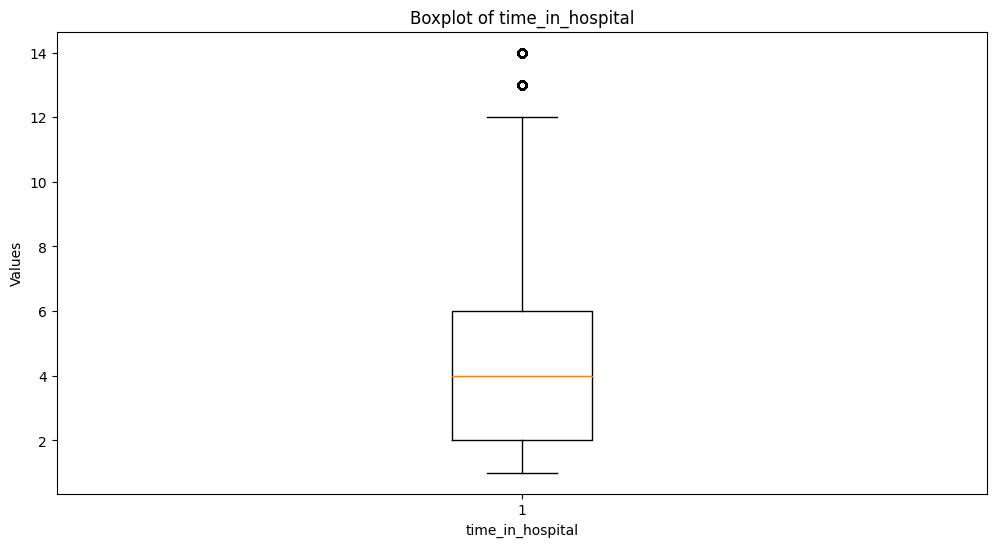

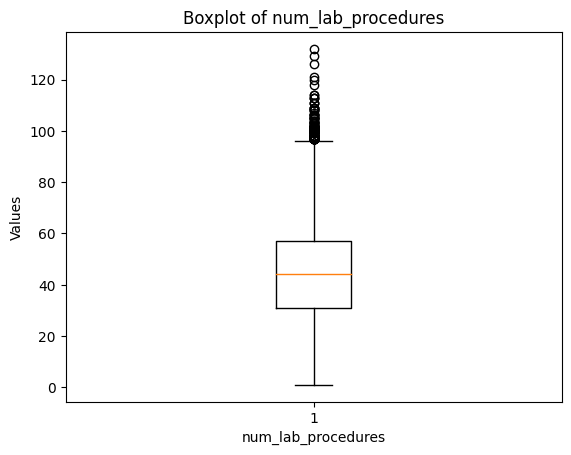

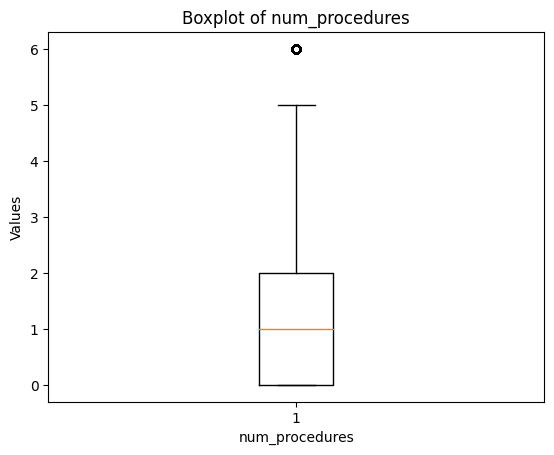

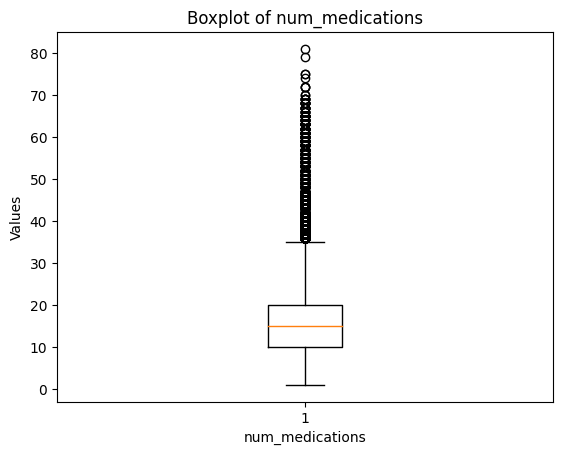

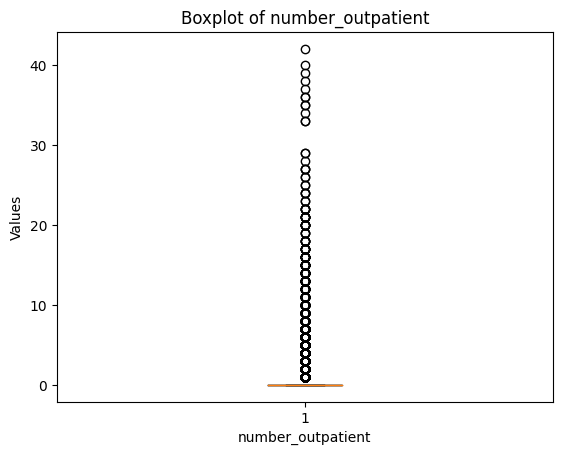

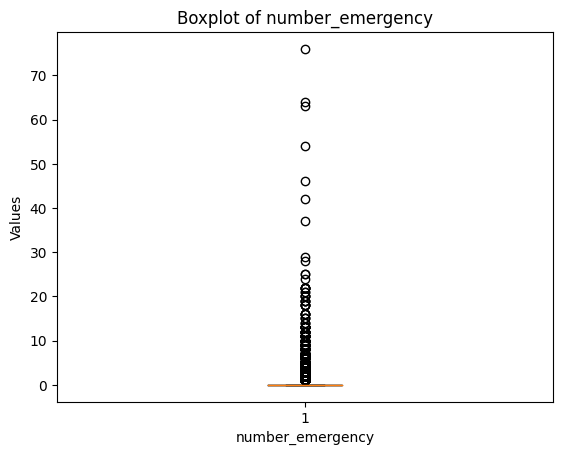

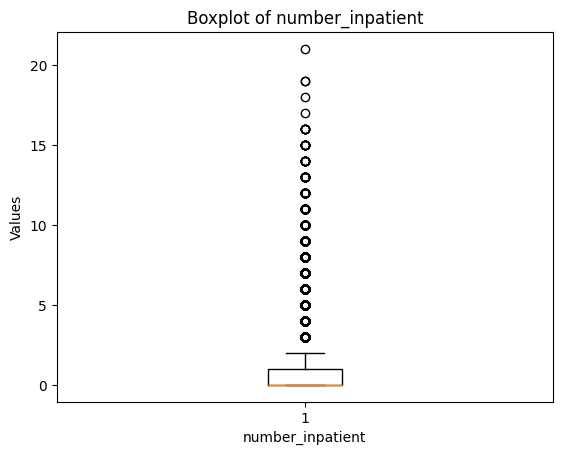

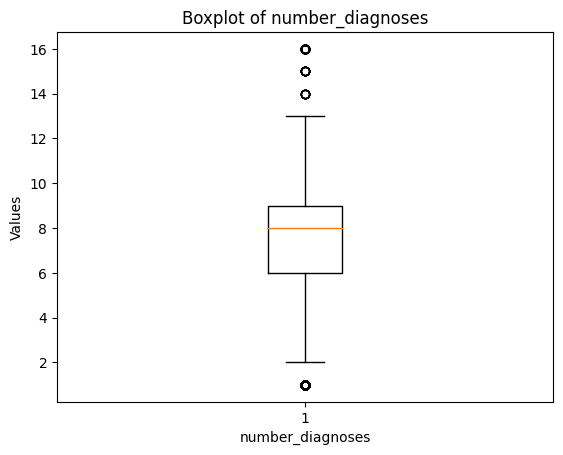

In [ ]:
plt.figure(figsize=(12, 6))
for col in df.select_dtypes(include='number').columns:
    plt.boxplot(df[col])
    plt.xlabel(col)
    plt.ylabel('Values')
    plt.title(f'Boxplot of {col}')
    plt.show()

De los diagramas de caja podemos concluir que existe una alta presencia de valores atípicos en las características numéricas del conjunto de datos.

In [ ]:
for i in [e for e in df.columns if df[e].dtype == object]:
    print("\n" + i + " frequency %:")
    print(df[i].value_counts(normalize=True))
    print(i + " cross-frequency % with readmitted:")
    print(pd.crosstab(df[i], df['readmitted'], rownames=[i], colnames=['readmitted'], normalize=True))


race frequency %:
Caucasian          0.747784
AfricanAmerican    0.188766
?                  0.022336
Hispanic           0.020017
Other              0.014799
Asian              0.006299
Name: race, dtype: float64
race cross-frequency % with readmitted:
readmitted            <30       >30        NO
race                                         
?                0.001847  0.005287  0.015202
AfricanAmerican  0.021176  0.065189  0.102402
Asian            0.000639  0.001582  0.004078
Caucasian        0.084429  0.266533  0.396822
Hispanic         0.002083  0.006309  0.011625
Other            0.001425  0.004383  0.008991

gender frequency %:
Female             0.537586
Male               0.462384
Unknown/Invalid    0.000029
Name: gender, dtype: float64
gender cross-frequency % with readmitted:
readmitted            <30       >30        NO
gender                                       
Female           0.060452  0.191793  0.285341
Male             0.051147  0.157489  0.253749
Unknown/Invalid  0

Para esta parte se muestra la distribución de cada variable categórica en terminos porcentuales y se muestra una tabla cruzada con la variable analizada y la variable objetivo para detectar relaciones entre estas variables con la variable objetivo.